# Spatio-Temporal Data Mining
__*A study on Location-Based Recommender Systems*__  
*Dr. Mitra Baratchi, Leiden University*  
*Hossein A. Rahmani, University of Zanjan*

# Recommender Systems in Location-Based Social Networks
In this notebook, we implement three classic recommneder system methods, which we define the basic of recommender systems.

## What is a Recommender Systesm?

Each person has own preferences and personality. *Recommender Systems* try to use your preferences to personalize your experiences on the web and any other applications, and answer some questtions like Who, Where, What etc. For example, where to eat, what to buy, or even who you should be friends with.

## Recommender Systems Types

Two most well known types of recommender systems approaches are:   

1. __Content Based (CB)__: The content-based approach is based on the contents, such as user profiles, attributes of the items etc. User profile shows user preferences or as another example based on the user profile we can see which genre of movies he likes.  
  
2. __Collaborative Filtering (CF)__: The popular and most used approach can be divided into __Memory-based__ and __Model-based__. The Memory-Based collaborative filtering approach can be divided into two main sections: __User-Item filtering__ and __Item-Item filtering__.  
  
3. __Hybrid Recommender Systems__: Models that use both ratings and content features are called Hybrid Recommender Systems where both Collaborative Filtering and Content-based Models are combined.



Now, we want to read our dataset (*preprocessed_data.csv*) then apply our methods. First, we implement two memory-based approaches and we should have an evaluation metric for output. Then, we use one of most popular and well-known approach in model-based section.  

As you know, in any programming language there are a lot of packages to make implementation easier. In Python, for data mining and data science tasks, there are some important packages like __Numpy__, __Pandas__, __Sklearn__.

In [1]:
# NumPy is the fundamental package for scientific computing with Python
# (http://www.numpy.org/).
import numpy as np

""" pandas is an open source, BSD-licensed library providing high-performance, 
easy-to-use data structures and data analysis tools for the Python programming 
language (https://pandas.pydata.org/). """
import pandas as pd

""" scikit-learn, Machine Learning in Python, Simple and efficient tools for 
data mining and data analysis. Importing sklearn.cross_validation triggers a 
deprecation warning with sklearn 0.18 (http://scikit-learn.org/stable). Changes 
from 0.17 to 0.18, including the major change from the cross_validation 
submodule to the model_selection submodule. """
from sklearn import model_selection as ms
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt
import matplotlib.pyplot as plt
from collections import defaultdict

First, we define data header and read data as a matrix structure. You can check data and the data structure by enabling *print(df)* in the following codes.So, you can get a sneak peek of the dataset. Next, let's count the number of unique users and locations.

In [11]:
header = ['user_id', 'location_id', 'frequency']
df = pd.read_csv('preprocessed_data/preprocessed_data.csv', sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_locations = df.location_id.unique().shape[0]
print('>> Number of users = ' + str(n_users))
print('>> Number of locations = ' + str(n_locations))

>> Number of users = 1779
>> Number of locations = 11456


We use the *scikit-learn* library to split the dataset into testing and training.  *model_selection.train_test_split* shuffles and splits the data into two datasets according to the percentage of test examples (test_size), which in this case is $0.20$.

In [12]:
train_data, test_data = ms.train_test_split(df, test_size=0.20)
print(">> Train data rows and columns:", train_data.shape)
print(">> Test data rows and columns:", test_data.shape)

>> Train data rows and columns: (46377, 3)
>> Test data rows and columns: (11595, 3)


### Memory Based Collaborative Filtering

As we said before, memory-based is divided into User-Item and Item-Item. The *User-Item collaborative filtering* method try to find similr users and based on the similar user's preferences (i.e. *like, rating, checkin etc*) recommend new things to users. In contrast, *Item-Item filtering* will take an item, find users who liked that item then find other items that those users or similar users also liked. So, based on taken item it makes a recommendation.



The similarity values between items in Item-Item Collaborative Filtering are measured by observing all the users who have rated both items and for User-Item Collaborative Filtering, the similarity values between users are measured by observing all the locations that are checked-in (check-in frequency) by both users. There are some distance measures, such as Cosine Similarity, Jaccard Similarity etc. [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is one the most used distance matrix in recommender systems. To this purpose, the check-in frequency considers as vectors in $n$-dimensional space and the similarity is calculated based on the angle between these vectors. The `Cosine Similrity` for user $u$ and $u'$ is $sim(u,u')=cos(\theta)=\frac{r_{u}.r_{u'}}{||r_{u}|| \ ||r_{u'}||}= \sum_i\frac{r_{ui}.r_{u'i}}{\sqrt{\sum_ir_{ui}^2}\sqrt{\sum_ir_{u'i}^2}}$  

The first step will be create two user-item matrices for traning and testing sets:

In [13]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_locations))

for checkin in train_data.itertuples():
    train_data_matrix[checkin[1], checkin[2]] = checkin[3]

# for RMSE
test_data_matrix = np.zeros((n_users, n_locations))
# for Precision and Recall
ground_truth_dic = defaultdict(set)

for checkin in test_data.itertuples():
    test_data_matrix[checkin[1], checkin[2]] = checkin[3]
    ground_truth_dic[int(checkin[1])].add(int(checkin[2]))

For calculating cosine similarity we have implemented a function and used NumPy function. Also, you can use [cosine_similarity](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) function from `sklearn`:

In [14]:
#user_similarity = cosine_similarity(train_data_matrix)
#item_similarity = cosine_similarity(train_data_matrix.T)

def cosine_similarity(train_matrix, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = train_matrix.dot(train_matrix.T) + epsilon
    elif kind == 'location':
        sim = train_matrix.T.dot(train_matrix) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

user_similarity = cosine_similarity(train_data_matrix, kind='user')
item_similarity = cosine_similarity(train_data_matrix, kind='location')

The output is a [n_samples_a, n_samples_b], a distance matrix $D$ such that $D_{i, j}$ is the distance between the $i$th and $j$th vectors of the given matrix $X$. Now, we can make the predictions for the check-in that not included with the data based on our similarity matrix. To evaluate the quality of our recommendation model we can then compare the predeictions with the test data.

For User-based Collaborative Filtering, we predict that a user's $u's$ checkin for location $i$ is given by the weighted sum of all other users' chekcin for location $i$ where the weighting is the `cosine similarity` between the each user and the input user u. For Item-based Collaborative Filterisng is some thing like that, too.

In [15]:
def predict(checkins, similarity, type='user'):
    if type == 'user':
        pred = similarity.dot(checkins)/np.array([np.abs(similarity).sum(axis=1)]).T
        
    elif type == 'item':
        pred = checkins.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
        
    return pred

user_prediction = predict(train_data_matrix, user_similarity, type='user')
item_prediction = predict(train_data_matrix, item_similarity, type='item')

### Evaluation

For evaluation there are many evaluation metrics (e.g. Root Mean Squared Error (RMSE), Precision, Recall etc). The RMSE is one of the most popular evaluation metrics to evaluate predictions. The RMSE is calculated by $RMSE=\sqrt{\frac{1}{N}\sum{(x_i-x'_i)^2}}$

To implement the RMSE you can make `square root` from the output of `mean_square_error` (MSE) function. It has been implemented in `sklearn`.

In [16]:
def mae(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_absolute_error(prediction, ground_truth)

def rmse(prediction, ground_truth):
    # prediction[ground_truth.nonzero()] to only consider predicted checkins
    # (ratings) that are in the dataset.
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [17]:
UB_MAE = mae(user_prediction, test_data_matrix)
UB_RMSE = rmse(user_prediction, test_data_matrix)
IB_MAE = mae(item_prediction, test_data_matrix)
IB_RMSE = rmse(item_prediction, test_data_matrix)
print('>> User-based CF MAE: ' + str(UB_MAE))
print('>> User-based CF RMSE: ' + str(UB_RMSE))
print('>> Item-based CF MAE: ' + str(IB_MAE))
print('>> Item-based CF RMSE: ' + str(IB_RMSE))

>> User-based CF MAE: 1.0382965627959388
>> User-based CF RMSE: 1.0701401733299463
>> Item-based CF MAE: 1.0400121741238249
>> Item-based CF RMSE: 1.0717810031377322


### Model Based Collaborative Filtering

Model-Based CF uses machine learning and data mining approach to make a model to predict ratings. In recent years, most of the model-based approaches are based on [Matrix Factorization](https://en.wikipedia.org/wiki/Matrix_decomposition) (MF), and MF approaches received great attention because they are better than memory-based approach for scalability and sparsity. As an unsupervised learning method, the goal of the MFs is to learn the latent preferences of users and latent attributes of items based on known ratings. Actually, in this method, a model tries to learn latent or hidden features of data characteristics to predict the unknown ratings. Consider a very sparse matrix with a lot of dimensions, MF restructures this matrix into a low-rank structure and we can represent it by multiplication of two low-rank matrices. The first matrix shows users and their latent preferences, as well as the second matrix, shows the items and their latent attributes.

As we said the sparsity is an important problem in the recommender systems or any data mining tasks, let's take a look at the sparsity level of our dataset:

In [9]:
sparsity = round(1.0 - len(df) / float(n_users * n_locations), 3)
print('>> The sparsity level is ' +  str(sparsity * 100) + '%')

>> The sparsity level is 99.7%


### Singular Value Decomposition (SVD)

[Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) or in short SVD is one the well-known and most used matrix factorization method. Collaborative Filtering or ratings can be formulated by approximating a matrix $X$ by using singular value decomposition. The general equation can be expressed by $X = U \times S \times V^{T}$. Matrix $X$ as an $n \times m$ matrix can be factorized to $U$, $S$ and $V$ :  
- $U$ is an $m \times r$ orthogonal matrix (*user's feature vectors in hidden feature space*)  
- $S$ is an $r \times r$ diagonal matrix (*singular values of X*)  
- $V^T$ is an $r \times n$ orthogonal matrix (*item's feature vectors in hidden feature space*)  

Now, we want to make a prediction by dot product of $U$, $S$, and $V^T$. To this purpose, we can use `svds` function from `scipy` package.

In [10]:
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k as r in formula.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix = np.diag(s)
svd_prediction = np.dot(np.dot(u, s_diag_matrix), vt)
SVD_RMSE = rmse(svd_prediction, test_data_matrix)
print('>> Model-based CF RMSE: ' + str(SVD_RMSE))

>> Model-based CF RMSE: 1.0680592311693529


## Experiments

In this secion, we will plot the evaluation metrics results. Out evaluation metrics here are __RMSE__, __Precision__, and __Recall__. You can find more inforation about Precision and Recall [here](https://en.wikipedia.org/wiki/Precision_and_recall).

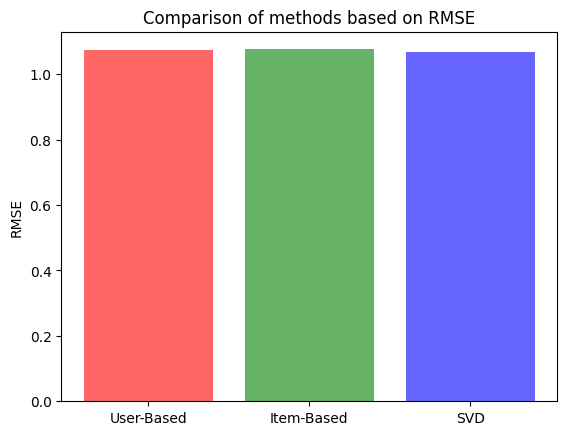

In [11]:
objects = ('User-Based', 'Item-Based', 'SVD')
y_pos = np.arange(len(objects))
performance = [UB_RMSE,IB_RMSE,SVD_RMSE]
 
plt.bar(y_pos, performance, color=['red', 'green', 'blue'], 
        align='center', alpha=0.6)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.title('Comparison of methods based on RMSE')
plt.show()

In [12]:
uPrecision5, uPrecision10, uPrecision15, uPrecision20 = [], [], [], []
iPrecision5, iPrecision10, iPrecision15, iPrecision20 = [], [], [], []
sPrecision5, sPrecision10, sPrecision15, sPrecision20 = [], [], [], []

uRecall5, uRecall10, uRecall15, uRecall20 = [], [], [], []
iRecall5, iRecall10, iRecall15, iRecall20 = [], [], [], []
sRecall5, sRecall10, sRecall15, sRecall20 = [], [], [], []

def precision_k(actual, predicted):
    return 1.0 * len(set(actual) & set(predicted)) / len(predicted)


def recall_k(actual, predicted):
    return 1.0 * len(set(actual) & set(predicted)) / len(actual)

all_uids = list(range(n_users))
all_lids = list(range(n_locations))
np.random.shuffle(all_uids)

for cnt, uid in enumerate(all_uids):
    if uid in ground_truth_dic:
        user_scores = [user_prediction[uid, lid]
                        if train_data_matrix[uid, lid] == 0 else -1
                            for lid in all_lids]
        
        item_scores = [item_prediction[uid, lid]
                        if train_data_matrix[uid, lid] == 0 else -1
                            for lid in all_lids]
        
        svd_scores = [svd_prediction[uid, lid]
                        if train_data_matrix[uid, lid] == 0 else -1
                            for lid in all_lids]
                
        user_scores = np.array(user_scores)
        item_scores = np.array(item_scores)
        svd_scores = np.array(svd_scores)
        
        user_predicted = list(reversed(user_scores.argsort()))[:100]
        item_predicted = list(reversed(item_scores.argsort()))[:100]
        svd_predicted = list(reversed(svd_scores.argsort()))[:100]
        
        actual = ground_truth_dic[uid]
        
        k = [5, 10, 15, 20]
        
        for i in k:
            u_precision = precision_k(actual, user_predicted[:i])
            u_recall = recall_k(actual, user_predicted[:i])
            
            i_precision = precision_k(actual, item_predicted[:i])
            i_recall = recall_k(actual, item_predicted[:i])
            
            s_precision = precision_k(actual, svd_predicted[:i])
            s_recall = recall_k(actual, svd_predicted[:i])
            
            if i == 5:
                uPrecision5.append(u_precision)
                iPrecision5.append(i_precision)
                sPrecision5.append(s_precision)
                
                uRecall5.append(u_recall)
                iRecall5.append(i_recall)
                sRecall5.append(s_recall)
                
            elif i == 10:
                uPrecision10.append(u_precision)
                iPrecision10.append(i_precision)
                sPrecision10.append(s_precision)
                
                uRecall10.append(u_recall)
                iRecall10.append(i_recall)
                sRecall10.append(s_recall)
                
            elif i == 15:                
                uPrecision15.append(u_precision)
                iPrecision15.append(i_precision)
                sPrecision15.append(s_precision)
                
                uRecall15.append(u_recall)
                iRecall15.append(i_recall)
                sRecall15.append(s_recall)
                
            elif i == 20:
                uPrecision20.append(u_precision)
                iPrecision20.append(i_precision)
                sPrecision20.append(s_precision)
                
                uRecall20.append(u_recall)
                iRecall20.append(i_recall)
                sRecall20.append(s_recall)            

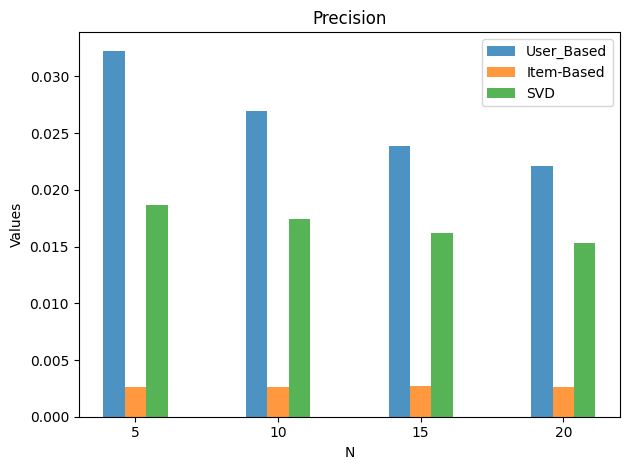

In [13]:
# data to plot
n_groups = 4
user = (np.mean(uPrecision5), np.mean(uPrecision10), 
        np.mean(uPrecision15), np.mean(uPrecision20))
item = (np.mean(iPrecision5), np.mean(iPrecision10), 
        np.mean(iPrecision15), np.mean(iPrecision20))
svd = (np.mean(sPrecision5), np.mean(sPrecision10), 
       np.mean(sPrecision15), np.mean(sPrecision20))
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, user, bar_width, alpha=opacity, label='User_Based') 
rects2 = plt.bar(index + bar_width, item, bar_width, 
                 alpha=opacity, label='Item-Based')
rects3 = plt.bar(index + bar_width + bar_width, svd, 
                 bar_width, alpha=opacity, label='SVD')
 
plt.xlabel('N')
plt.ylabel('Values')
plt.title('Precision')
plt.xticks(index + bar_width, ('5', '10', '15', '20'))
plt.legend()
 
plt.tight_layout()
plt.show()

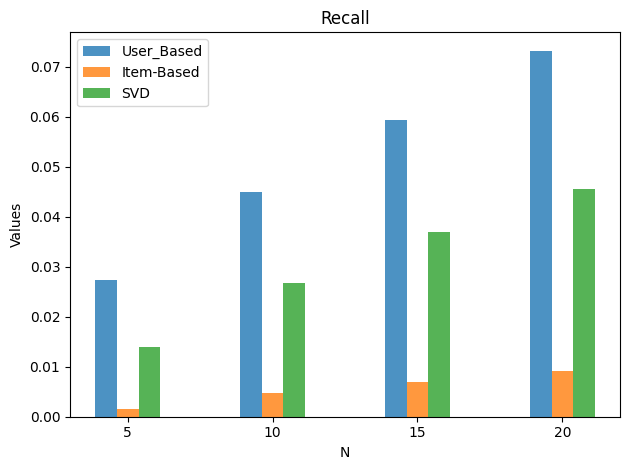

In [14]:
# data to plot
n_groups = 4
user = (np.mean(uRecall5), np.mean(uRecall10), 
        np.mean(uRecall15), np.mean(uRecall20))
item = (np.mean(iRecall5), np.mean(iRecall10), 
        np.mean(iRecall15), np.mean(iRecall20))
svd = (np.mean(sRecall5), np.mean(sRecall10), 
       np.mean(sRecall15), np.mean(sRecall20))
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, user, bar_width, alpha=opacity, label='User_Based') 
rects2 = plt.bar(index + bar_width, item, bar_width, 
                 alpha=opacity, label='Item-Based')
rects3 = plt.bar(index + bar_width + bar_width, svd, 
                 bar_width, alpha=opacity, label='SVD')
 
plt.xlabel('N')
plt.ylabel('Values')
plt.title('Recall')
plt.xticks(index + bar_width, ('5', '10', '15', '20'))
plt.legend()
 
plt.tight_layout()
plt.show()

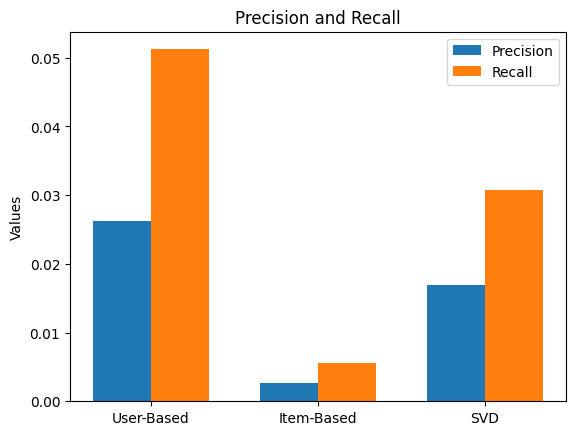

In [15]:
N = 3
means_precision = (np.mean(uPrecision5 + uPrecision10 + uPrecision15 + uPrecision20),
                   np.mean(iPrecision5 + iPrecision10 + iPrecision15 + iPrecision20),
                   np.mean(sPrecision5 + sPrecision10 + sPrecision15 + sPrecision20))

means_recall = (np.mean(uRecall5 + uRecall10 + uRecall15 + uRecall20),
                   np.mean(iRecall5 + iRecall10 + iRecall15 + iRecall20),
                   np.mean(sRecall5 + sRecall10 + sRecall15 + sRecall20))

ind = np.arange(N) 
width = 0.35

plt.bar(ind, means_precision, width, label='Precision')
plt.bar(ind + width, means_recall, width, label='Recall')

plt.ylabel('Values')
plt.title('Precision and Recall')

plt.xticks(ind + width / 2, ('User-Based', 'Item-Based', 'SVD'))
plt.legend(loc='best')
plt.show()

## Conclusion

Now, we have implemented two basic approaches for location-based recommender systems. As you saw, the Memory-based CF algorithms are easy to implement and the result has appropriate prediction quality. The main challenges in Memory-based approaches are *scalability* and *cold-start* problem. They are not suitable for a real-world scenario, and they have problems when a new user or item added to the system (i.e. cold-start). In contrast, Model-Based CF approaches are scalable and can handle when data is sparse but also suffer from the cold-start problem. Also, more recent work in the Model-based CF minimizes the squared error by applying alternating least square or *stochastic gradient descent* and uses regularization terms to prevent overfitting.